# Intro

Slightly richer k-NN implementation than the previous one

In [18]:
%pylab inline
import numpy as np
import random
import pylab
import time

Populating the interactive namespace from numpy and matplotlib


### Minkowski distance definition

In [19]:
def minkowski_mat(x,Y,p=2):
    return (np.sum((np.abs(x-Y))**p,axis=1))**(1.0/p)

### Plotting functions

In [20]:
def conf_matrix(testlabels, predlabels):

	n_classes = int(max(testlabels))
	matrix = np.zeros((n_classes,n_classes))

	for (test,pred) in zip(testlabels, predlabels):
		matrix[test-1,pred-1] += 1

	return matrix

In [21]:
# function plot
def gridplot(classifier,train,test,n_points=50):

    train_test = np.vstack((train,test))
    (min_x1,max_x1) = (min(train_test[:,0]),max(train_test[:,0]))
    (min_x2,max_x2) = (min(train_test[:,1]),max(train_test[:,1]))

    xgrid = np.linspace(min_x1,max_x1,num=n_points)
    ygrid = np.linspace(min_x2,max_x2,num=n_points)

	# calculates the cartesian product between two lists
    # and stores the result in an array
    thegrid = np.array(combine(xgrid,ygrid))

    counts = classifier.compute_predictions(thegrid)
    predictedClasses = np.argmax(counts,axis=1)+1

    # The grid
    # To get a better looking grid:
    #props = dict( alpha=0.3, edgecolors='none' )
    #pylab.scatter(thegrid[:,0],thegrid[:,1],c = classesPred, s=50, edgecolors='none')
    pylab.pcolormesh(xgrid, ygrid, predictedClasses.reshape((n_points, n_points)).T, alpha=.3)
	# Training data points
    pylab.scatter(train[:,0], train[:,1], c = train[:,-1], marker = 'v', s=150)
    # Test data points
    pylab.scatter(test[:,0], test[:,1], c = test[:,-1], marker = 's', s=150)

    ## A hack, since pylab is lacking this functionality... :(
    h1, = pylab.plot([min_x1], [min_x2], marker='o', c = 'w',ms=5) 
    h2, = pylab.plot([min_x1], [min_x2], marker='v', c = 'w',ms=5) 
    h3, = pylab.plot([min_x1], [min_x2], marker='s', c = 'w',ms=5) 
    handles = [h1,h2,h3]
    ## End of hack :)

    labels = ['grid','train','test']
    pylab.legend(handles,labels)

    pylab.axis('equal')
    pylab.show()
    
## http://code.activestate.com/recipes/302478/
def combine(*seqin):
    '''returns a list of all combinations of argument sequences.
for example: combine((1,2),(3,4)) returns
[[1, 3], [1, 4], [2, 3], [2, 4]]'''
    def rloop(seqin,listout,comb):
        '''recursive looping function'''
        if seqin:                       # any more sequences to process?
            for item in seqin[0]:
                newcomb=comb+[item]     # add next item to current comb
                # call rloop w/ rem seqs, newcomb
                rloop(seqin[1:],listout,newcomb)
        else:                           # processing last sequence
            listout.append(comb)        # comb finished, add to list
    listout=[]                      # listout initialization
    rloop(seqin,listout,[])         # start recursive process
    return listout

## KNN Class

In [22]:
class knn:
    def __init__(self,n_classes, dist_func=minkowski_mat, nn=1):
        self.n_classes = n_classes
        self.dist_func = dist_func
        self.nn = nn

    # The train function for knn is really only storing the dataset
    def train(self, train_inputs, train_labels):
        self.train_inputs = train_inputs
        self.train_labels = train_labels

    ###
    # The prediction function takes as input:
    #   test_data - Unlabeled test data points
    # and returns a matrix containing counts for each test set example. 
    # Each row of this matrix contains, for each class, the number of 
    # neighbors belonging to this class. 
    ###
    def compute_predictions(self, test_data):
        # Initialization of the matrix to return
        num_test = test_data.shape[0]
        counts = np.zeros((num_test,self.n_classes))

        # For each test datapoint
        for (i,ex) in enumerate(test_data):
            # i is the row index
            # ex is the i'th row

            # Find the distances to each training set point
            # using dist_func
            dist = self.dist_func(ex,train_inputs)
            # Go through the training set to find the 
            # neighbors of the current point (ex)
            indices = np.argpartition(dist,range(self.nn))[:self.nn] # find indices of k-NN
            neighbors = self.train_labels[indices] # get classes at those indices

            # Calculate the number of neighbors belonging to each class
            # and write them in counts[i,:]
            classes = np.unique(self.train_labels) # get a row vector for storing the counts
            classes_for_i, counts_for_i = np.unique(neighbors,return_counts=True) # frequency table for each class
            
            #Insert the counts into the correct columns of counts
            for c in range(len(classes_for_i)):
                for c_2 in range(len((classes))):
                    if classes_for_i[c] == classes[c_2]:
                        counts[i][c_2] = counts_for_i[c]
                        break
        return counts

## Loading and splitting the data

In [23]:
# load iris
iris = np.loadtxt('iris.txt')
data = iris

# Number of classes
n_classes = 3
# Size of training set
n_train = 100

# The columns (features) on which to train our model
# For gridplot to work, len(train_cols) should be 2
train_cols = [0,1]
# The index of the column containing the labels
target_ind = [data.shape[1] - 1]

# Comment to have random (non-deterministic) results 
random.seed(3395)
# Randomly choose indexes for the train and test dataset
inds = list(range(data.shape[0]))
random.shuffle(inds)
train_inds = inds[:n_train]
test_inds = inds[n_train:]

# Split the data into both sets
train_set = data[train_inds,:]
train_set = train_set[:,train_cols + target_ind]
test_set = data[test_inds,:]
test_set = test_set[:,train_cols + target_ind]

# Separate the test set into inputs and labels
test_inputs = test_set[:,:-1]
test_labels = test_set[:,-1].astype('int32')
train_inputs = train_set[:, :-1]
train_labels = train_set[:, -1].astype('int32')

## Initialization and training of the classifier

In [24]:
# Number of neighbors (k) for knn
k = 2
print("We will train ",k, "-NN on ", n_train, " training set examples")

# Create the classifier
model = knn(n_classes,dist_func = minkowski_mat, nn = k)
# We train the model
model.train(train_inputs, train_labels)
# We get predictions
t1 = time.time()
counts = model.compute_predictions(test_inputs)
t2 = time.time()
print('It took ', t2-t1, ' seconds to calculate the predictions on ', test_inputs.shape[0],' test set examples')

# Majority vote (+1 since our classes are labeled from 1 to n)
classes_pred = np.argmax(counts,axis=1)+1

We will train  2 -NN on  100  training set examples
It took  0.03752470016479492  seconds to calculate the predictions on  50  test set examples


## Confusion matrix and decision boundary

The confusion matrix is:
[[18.  0.  0.]
 [ 0. 14.  4.]
 [ 0.  8.  6.]]
The test error is  24.0 %


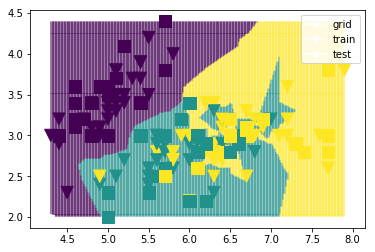

It took  7.9178125858306885  seconds to calculate the predictions on 40000  points of the grid
We will save the plot into grid__k=2_c1=0_c2=1.png


<Figure size 432x288 with 0 Axes>

In [25]:
# Run the tests
# Confusion Matrix 
confmat = conf_matrix(test_labels, classes_pred)
print('The confusion matrix is:')
print(confmat)

# Test error
sum_preds = np.sum(confmat)
sum_correct = np.sum(np.diag(confmat))
print("The test error is ", 100*(1.0 - (float(sum_correct) / sum_preds)),"%")

# The grid size will be = grid_size x grid_size
grid_size = 200

if len(train_cols) == 2:
    # Decision boundary
    t1 = time.time()
    gridplot(model, train_set, test_set, n_points = grid_size)
    t2 = time.time()
    print('It took ', t2-t1, ' seconds to calculate the predictions on', grid_size * grid_size, ' points of the grid')
    filename = 'grid_' + '_k=' + str(k) + '_c1=' + str(train_cols[0]) + '_c2=' + str(train_cols[1])+'.png'
    print('We will save the plot into {}'.format(filename))
    pylab.savefig(filename,format='png')
else:
    print('Too many dimensions (', len(train_cols),') to print the decision boundary')